In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB2

In [3]:
data_dir = '/kaggle/input/teknofest/Teknofest_Saglıkta_Yapay_Zeka'

#label_names
label_names = ['normal','stroke']

num_classes = len(label_names)

EPOCHS = 100
IMG_SIZE = 260
BATCH_SIZE = 32
IMG_SHAPE = (260,260)

AUTOTUNE = tf.data.AUTOTUNE
#device = "TPU-VM"
device = "GPU"
SEED = 1

In [4]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    tf.random.set_seed(SEED)
    #keras.utils.set_random_seed(seed=config.SEED)
    print('seeding done!!!')
    
seeding(SEED)

seeding done!!!


In [5]:
print(device)
if 'TPU' in device: 
    tpu = 'local' if device == 'TPU-VM' else None
    #tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

    print("Conncecting to TPU...")
    try: 
        #tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
        #tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        #tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        print("TPU:" , tpu)
        strategy  = tf.distribute.TPUStrategy(tpu) 
    except: 
        device = 'GPU'
        
if device == 'GPU' or device == 'CPU':
    ngpu = len(tf.config.experimental.list_physical_devices('GPU'))
    if ngpu > 1: 
        print("Using Multi GPU")
        strategy = tf.distribute.MirroredStrategy()
    elif ngpu==1: 
        print("Using Single GPU")
        strategy = tf.distribute.get_strategy()
    else:
        print("Using CPU")
        strategy = tf.distribute.get_strategy()
        device = 'CPU'
        
if device == "GPU":
    print("Number of GPU Available: ", ngpu)
    
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

BATCH_SIZE = 16 * strategy.num_replicas_in_sync
print(BATCH_SIZE)

GPU
Using Multi GPU
Number of GPU Available:  2
REPLICAS: 2
32


In [6]:
print(device)

GPU


In [7]:
# Start weights at zero
num_classes = len(label_names)
weights = [0] * num_classes  # e.g. [0, 0, 0, .. 0]

tot = 0
for idx, label in enumerate(label_names):
    cnt_label = len(os.listdir(os.path.join(f"{data_dir}/train", f"{label}/png")))
    print(cnt_label)
    weights[idx] = cnt_label  # really a count right now
    tot += cnt_label

class_frequencies = weights
class_frequencies = [ w / tot for w in weights ]  # [0.018897364771151177, 0.0297041 ...

weights = [ 1.0 / cnt for cnt in weights ]
weights = [ tot * w / num_classes for w in weights ]

class_weight = {}
for i in range(num_classes):
    class_weight[i] = weights[i]
    print(f"Weight for class {i}: " + '{:.2f}'.format(weights[i]))

3541
1778
Weight for class 0: 0.75
Weight for class 1: 1.50


In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_ds= tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    labels="inferred",
    label_mode="categorical",
    class_names=label_names,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=7,
    crop_to_aspect_ratio=True,
)

# Load validation data
val_ds = image_dataset_from_directory(
    f"{data_dir}/validation",
    labels="inferred",
    label_mode="categorical",
    class_names=label_names,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=7,
    crop_to_aspect_ratio=True,
)

test_ds = image_dataset_from_directory(
    f"{data_dir}/test",
    labels="inferred",
    label_mode="categorical",
    class_names=label_names,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    shuffle=True,
    seed=7,
    crop_to_aspect_ratio=True,
)

Found 5319 files belonging to 2 classes.
Found 664 files belonging to 2 classes.
Found 667 files belonging to 2 classes.


In [9]:
#train_ds = train_ds.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#val_ds = val_ds.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
#test_ds = test_ds.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [10]:
with strategy.scope():
    image_augmentation = tf.keras.models.Sequential([
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=7),
    ])

In [11]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
with strategy.scope():

    METRICS = [
        #pauc,
        tf.keras.metrics.BinaryCrossentropy(name='binary_crossentropy'),
        # tf.keras.metrics.TruePositives(name='tp'),
        # tf.keras.metrics.TrueNegatives(name='tn'),
        # tf.keras.metrics.FalsePositives(name='fp'),
        # tf.keras.metrics.FalseNegatives(name='fn')
        #tf.keras.metrics.BinaryAccuracy(name='BinaryAccuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.F1Score(name='f1'),
        tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
    ]

In [13]:
#CNN Models
#We'll first take off the old head from the model (with include_top=False) and replace it with our own classifier for our specific data. First we'll freeze all the model weights and only train our classifier head.

def build_model_EfficientNetB2(num_classes, metrics=METRICS, output_bias=None):

    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    # Inputs and augmentation
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    aug_inputs = image_augmentation(inputs)

    #rescaled_inputs = tf.keras.layers.Rescaling(1.0 / 255)(aug_inputs)
    rescaled_inputs = aug_inputs
    
    # Base model
    model = EfficientNetB2(include_top=False, input_tensor=rescaled_inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top like in original paper
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(num_classes,
                                    activation="softmax",
                                    # bias otherwise defaults to zeros
                                    bias_initializer=output_bias,
                                    name="pred")(x)

    # Compile Model
    model = tf.keras.Model(inputs, outputs, name="EfficientNetB2")

    # Using a large learning rate for this part since most weights are fixed
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics,
    )

    return model

In [14]:
#Build models

tf.keras.backend.clear_session()
    
with strategy.scope():
    #model_1 = build_model_Xception(num_classes)
    model_1 = build_model_EfficientNetB2(num_classes)
    #model_1 = build_model_EfficientNetV2M(num_classes)
    #model_1 = build_model_EfficientNetV2L(num_classes)
    #model_1 = build_model_ConvNeXtBase(num_classes)
    #model_1 = build_model_ConvNeXtLarge(num_classes)
    models = [model_1]
   
# model.summary(show_trainable=True)
print("The following models are being trained - ")
for x in models:
    print(f"{x.name}")

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
The following models are being trained - 
EfficientNetB2


In [15]:
#tf.keras.utils.plot_model(model_1, show_shapes=True)

In [16]:
#Callbacks
#We'll use Early Stopping to stop the model if the validation loss stops improving. We'll also reduce the learning rate when learning starts to plateau.

# Use early stopping to train as long as possible
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
)

# And Reduce LR on Plateau to lower learning rate if stagnating
reduce_lr_on_plateau_cb = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,         # reduce by half (divide by 2)
        patience=2,         # must be lower than patience of early stopping
)

In [17]:
def plot_history(model,history):
    
    # Plot the loss and accuracy curves for training and validation
#     plt.title(model.name)
    fig, ax = plt.subplots(2,1)
    ax[0].set_title(f"{model.name} Loss")
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss")
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].set_title(f"\n{model.name} Accuracy")
    ax[1].plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    fig.tight_layout()
    
def pred_confusion(model):
   
    true_labels = []
    for _, tmp_labels in test_ds:
        true_labels.append(tmp_labels.numpy())

    true_labels = np.concatenate(true_labels)
    true_labels = np.argmax(true_labels, axis=1)  # (1732,)

    print("Evaluating on test data")
    results = model.evaluate(test_ds, batch_size=BATCH_SIZE)
    
    print("Generating prediction data")

    test_predictions_baseline = model.predict(test_ds, batch_size=BATCH_SIZE)
    predicted_classes = np.argmax(test_predictions_baseline, axis=1)
    print(classification_report(true_labels, predicted_classes, target_names=label_names))


    cm = confusion_matrix(true_labels, predicted_classes)
    cm_display = ConfusionMatrixDisplay(cm,display_labels =label_names).plot()

In [18]:
history = []
for i in models:
    x = i.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    class_weight=class_weight,  # use our class weights here
                    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb],
                    verbose = 2
                   )
    history.append(x)
    print(f"{i.name} Training Complete")
    

Epoch 1/100
167/167 - 58s - 347ms/step - binary_crossentropy: 0.8381 - categorical_accuracy: 0.6774 - f1: 0.6484 - loss: 0.7479 - precision: 0.6774 - recall: 0.6774 - val_binary_crossentropy: 0.5827 - val_categorical_accuracy: 0.8223 - val_f1: 0.7832 - val_loss: 0.4251 - val_precision: 0.8223 - val_recall: 0.8223 - learning_rate: 0.0100
Epoch 2/100
167/167 - 15s - 90ms/step - binary_crossentropy: 0.6707 - categorical_accuracy: 0.7624 - f1: 0.7375 - loss: 0.5426 - precision: 0.7624 - recall: 0.7624 - val_binary_crossentropy: 0.5782 - val_categorical_accuracy: 0.8102 - val_f1: 0.7699 - val_loss: 0.4802 - val_precision: 0.8102 - val_recall: 0.8102 - learning_rate: 0.0100
Epoch 3/100
167/167 - 15s - 93ms/step - binary_crossentropy: 0.6552 - categorical_accuracy: 0.7609 - f1: 0.7380 - loss: 0.5168 - precision: 0.7609 - recall: 0.7609 - val_binary_crossentropy: 0.5723 - val_categorical_accuracy: 0.8373 - val_f1: 0.7849 - val_loss: 0.4120 - val_precision: 0.8373 - val_recall: 0.8373 - learnin

For model EfficientNetB2 - 
Evaluating on test data
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - binary_crossentropy: 0.4917 - categorical_accuracy: 0.8142 - f1: 0.7831 - loss: 0.4174 - precision: 0.8142 - recall: 0.8142
Generating prediction data
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 391ms/step
              precision    recall  f1-score   support

      normal       0.85      0.93      0.89       444
      stroke       0.82      0.66      0.73       223

    accuracy                           0.84       667
   macro avg       0.83      0.80      0.81       667
weighted avg       0.84      0.84      0.83       667

Model Saved as EfficientNetB2_classifier_head.keras
__________


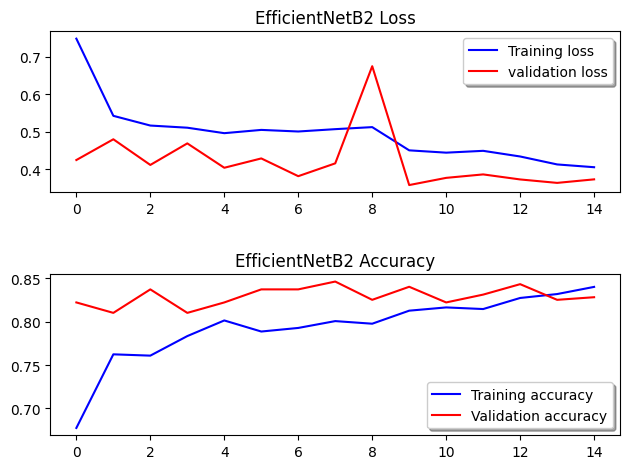

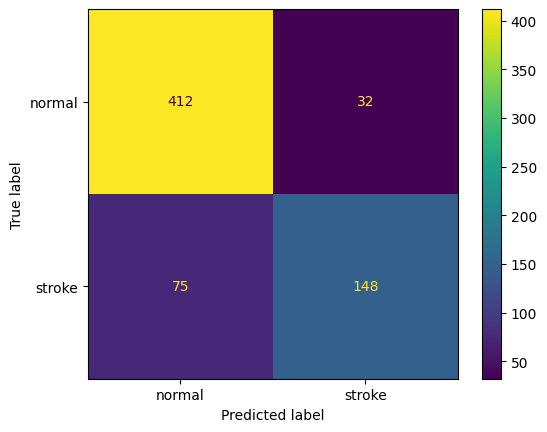

In [19]:
#Plot loss and accuracy curves
#Compute confusion matrix on test set (not leaderboard)

for i,j in zip(models,history):
    print(f"For model {i.name} - ")
    plot_history(i,j)
    pred_confusion(i)
    i.save(f'{i.name}_classifier_head.keras')
    print(f"Model Saved as {i.name}_classifier_head.keras")
    print("__________")

In [20]:
#Unfreeze and Fine-Tune
#Now that we've set up our classifier at the end using custom datasets (instead of the ImageNet dataset it was originally trained on), we can unfreeze all the weights and carefully fine-tune the entire model.

def unfreeze_model(model, metrics=METRICS):
    
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
    with strategy.scope():
        # Use a much smaller learning rate now to start
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    
        # Recompile to 'freeze' which layers are frozen (not trainable)
        model.compile(
            optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics
        )

for i in models:
    unfreeze_model(i)

history = []
for i in models:
    print(f"Finetuning {i.name} model - ")
    x = i.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    class_weight=class_weight,  # use our class weights here
                    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb],
                    verbose = 2
                   )
    history.append(x)
    print(f"{i.name} Training Complete")

Finetuning EfficientNetB2 model - 
Epoch 1/100
167/167 - 94s - 561ms/step - binary_crossentropy: 0.5077 - categorical_accuracy: 0.8244 - f1: 0.8034 - loss: 0.4310 - precision: 0.8244 - recall: 0.8244 - val_binary_crossentropy: 0.4415 - val_categorical_accuracy: 0.8554 - val_f1: 0.8208 - val_loss: 0.3493 - val_precision: 0.8554 - val_recall: 0.8554 - learning_rate: 1.0000e-05
Epoch 2/100
167/167 - 48s - 287ms/step - binary_crossentropy: 0.5003 - categorical_accuracy: 0.8451 - f1: 0.8268 - loss: 0.4092 - precision: 0.8451 - recall: 0.8451 - val_binary_crossentropy: 0.4189 - val_categorical_accuracy: 0.8584 - val_f1: 0.8227 - val_loss: 0.3281 - val_precision: 0.8584 - val_recall: 0.8584 - learning_rate: 1.0000e-05
Epoch 3/100
167/167 - 48s - 290ms/step - binary_crossentropy: 0.4813 - categorical_accuracy: 0.8511 - f1: 0.8339 - loss: 0.3801 - precision: 0.8511 - recall: 0.8511 - val_binary_crossentropy: 0.3990 - val_categorical_accuracy: 0.8675 - val_f1: 0.8398 - val_loss: 0.3190 - val_pre

For model EfficientNetB2 - 
Evaluating on test data
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - binary_crossentropy: 0.2940 - categorical_accuracy: 0.9042 - f1: 0.8911 - loss: 0.2353 - precision: 0.9042 - recall: 0.9042
Generating prediction data
21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 417ms/step
              precision    recall  f1-score   support

      normal       0.92      0.95      0.93       444
      stroke       0.90      0.83      0.86       223

    accuracy                           0.91       667
   macro avg       0.91      0.89      0.90       667
weighted avg       0.91      0.91      0.91       667

Model Saved as EfficientNetB2_finetuned.keras
__________


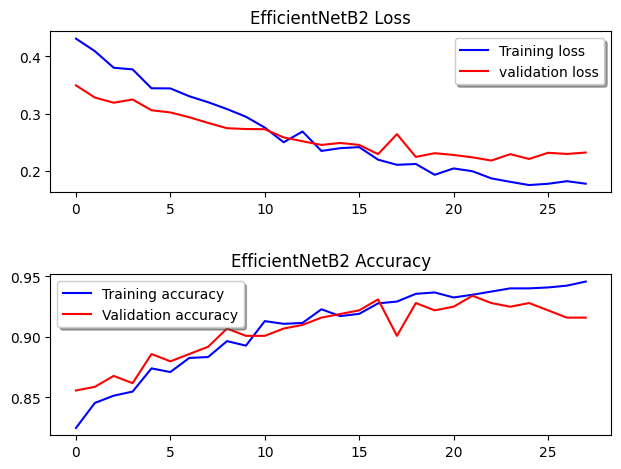

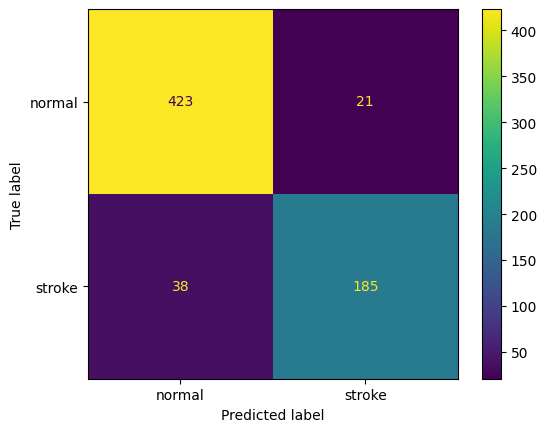

In [21]:
#Plot loss and accuracy curves
#Compute confusion matrix on test set (not leaderboard)

for i,j in zip(models,history):
    print(f"For model {i.name} - ")
    plot_history(i,j)
    pred_confusion(i)
    i.save(f'{i.name}_finetuned.keras')
    print(f"Model Saved as {i.name}_finetuned.keras")
    print("__________")